# Investigating Supernova Lightcurves

*An Introductory Lab activity for matplotlib and scipy curve_fit*

In [5]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt #plotting tools

In [6]:
#optional - import data directly from Kaggle
import kagglehub 

## Activity 1: Examine Data from SN 1987A

### First, let's grab data from Kaggle and plot it

In [7]:
# if you have kaggle hub installed, you can simply run this cell. If not, use the cell below

datapath = kagglehub.dataset_download("jonathanmushkin/lightcurve")

data=np.loadtxt(datapath+'/1987A bolometric lightcurve.txt',delimiter=',')

### Examine the data once it's been imported

In [8]:
#determine the shape of data
print('Shape of data: ',np.shape(data))

#Split the data into two 1D arrays
days=data[0]  #fill in the blank
loglum=data[1] # fill in the blank

Shape of data:  (2, 45)


### Plot the data to see what we're working with 

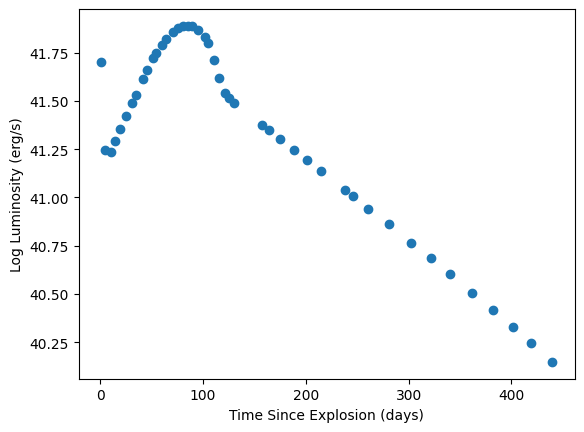

In [9]:
plt.figure()
plt.scatter(days,loglum)
plt.ylabel('Log Luminosity (erg/s)')
plt.xlabel('Time Since Explosion (days)')
plt.show()

### Determine where the peak (maximum) of the lightcurve occurs, and it's value in erg/s

In [10]:
idx=np.argmax(loglum)# find the index of the maximum value of loglum

maxtime=days[idx]
maxlum=10**loglum[idx]

#print the results
print(f'The maximum lumniosity is: {maxlum:.2e} erg/s at {maxtime:.1f} days')
print(f'Note, we will move to different analysis for now, but will return to this later...')

The maximum lumniosity is: 7.74e+41 erg/s at 89.6 days
Note, we will move to different analysis for now, but will return to this later...


## Activity 2: What powers a supernova explosion at late times (>120 days from explosion)?

### Notice in the plot from activity 1, around 120 days is roughly where the data starts to look linear (but is not really linear because of the y-axis data is log(luminosity) rather than luminosity

In [11]:
#determine where the data excceeds 120 days
idx=np.where(days>120)[0][0]

#slice the arrays we have to only contain data greater than 120 days from explosion
latetime=days[idx:]
lateLClog=loglum[idx:]

In [12]:
#let's convert the late time data from log luminosity to linear space which will be useful for the analysis
lateLC=10**lateLClog

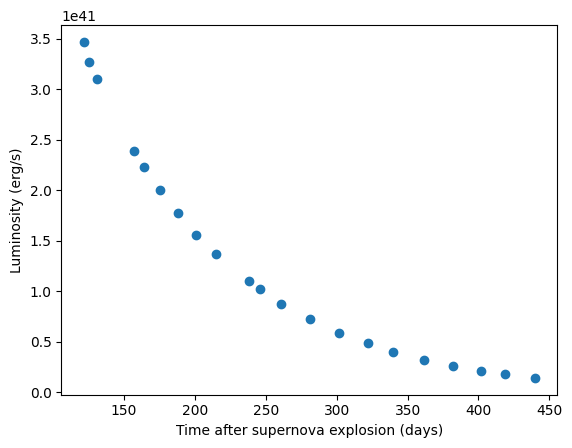

In [13]:
# Plot the late time light curve
# Include labels for x & y axes including units
plt.figure()
plt.scatter(latetime, lateLC)
plt.ylabel('Luminosity (erg/s)')
plt.xlabel('Time after supernova explosion (days)')
plt.show()

### Notice this looks like exponential decay. That's because the late time energy is from radioactive decay!

### Let's try to determine the nuclide by determining the half life

In [14]:
#develop a function that follows the expected decay law
def emissionModel(t,A,tau):
    x = A * np.exp(-t/tau)
    return x

In [31]:
# let's start with a 'by eye' fitting of the data. 

A = 3.5E41 # Adjust value as neeed
tau = 100. # Adjust value as needed

#produce values of time and expected emission for the model for given values of A and tau
modeltime = np.linspace(0,350,201)
modelvalues=emissionModel(modeltime,A,tau)

# note we will need to 'shift' the time of the data so that the start is near zero for the model to display correctly
timeshifted=latetime-120.

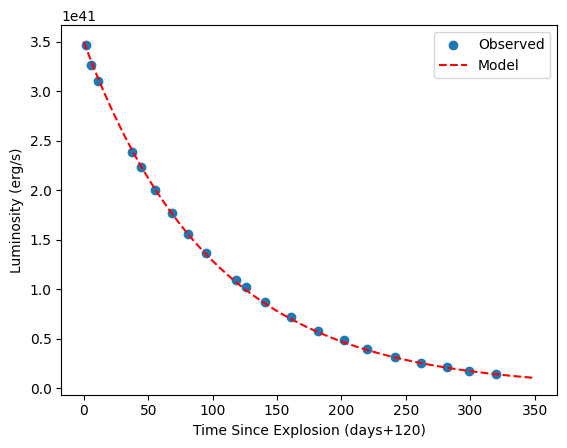

In [32]:
# plot the data and model to determine the best fit 'by eye'
# Note this doesn't have to be perfect, but we want somewhat close.

plt.figure()
plt.scatter(timeshifted,lateLC, label='Observed')
plt.plot(modeltime,modelvalues,'r--',label='Model')
plt.ylabel('Luminosity (erg/s)')
plt.xlabel('Time Since Explosion (days+120)')
plt.legend()
plt.show()

### Once we have a satisfactory fit above, let's look at trying this again with scipy curve_fit

In [33]:
from scipy.optimize import curve_fit

#perform curve fit
opt=curve_fit(emissionModel,timeshifted,lateLC)

#examine results
print(f'fitted A value is: {opt[0][0]:.2e}')
print(f'fitted tau value is: {opt[0][1]:.2e}')

fitted A value is: 1.00e+00
fitted tau value is: 1.00e+00


C:\Users\Joseph\AppData\Local\Temp\ipykernel_6400\65799395.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  opt=curve_fit(emissionModel,timeshifted,lateLC)


### Note these values clearly do not match what we determined earlier using our 'by eye' approach. That's because the fit failed!

In [34]:
# many complex models (things other than linear) can run into problems with auto fitting.
# it is therefore important to provide an initial guess to improve the fitting process
# let's use what we determiend before in the 'by eye' version

#perform curve fit- take 2
opt=curve_fit(emissionModel,timeshifted,lateLC,p0=[A,tau])

#examine results
print(f'fitted A value is: {opt[0][0]:.2e}')
print(f'fitted tau value is: {opt[0][1]:.2e}')

fitted A value is: 3.47e+41
fitted tau value is: 1.02e+02


### Plot the results to check for consistency

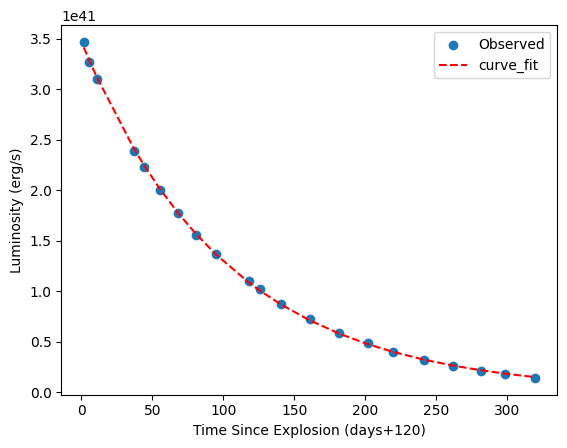

In [35]:
plt.figure()
plt.scatter(timeshifted,lateLC, label='Observed')
plt.plot(timeshifted,emissionModel(timeshifted,opt[0][0],opt[0][1]),'r--',label='curve_fit')
plt.ylabel('Luminosity (erg/s)')
plt.xlabel('Time Since Explosion (days+120)')
plt.legend()
plt.show()

In [36]:
### use our tau value to determine the half life

halflife=np.log(2)*tau

print(f'The best-fit value for the half-life is: {halflife:.2f} days')

The best-fit value for the half-life is: 69.31 days


### From spectroscopy, we know that SN explosions that have large amounts of $^{56}\!$ Ni (6.1 days), which decays to $^{56}\!$ Co (77.2 days), which decays to $^{56}\!$ Fe (stable)

### Which species is more likely responsible? Why don't either half lives match exactly the expecation? take a moment to think on this one, but ask Dr. Hankins if you are still unsure about the way to interpret these results.

## Activity 3: Estimating $^{56}\!$ Ni Mass 

### Clearly the decay chain from $^{56}\!$ Ni -> $^{56}\!$ Co -> $^{56}\!$ Fe is important for explaining SN lightcurves at late times, but how much $^{56}\!$ Ni is in the SN explosion?

### Arnett's law provides a relation of the peak lumnosity to the Ni-56 mass via:

### $L_{peak} \approx \epsilon_{\mathrm{Ni56}} M_{\mathrm{Ni56}}  \lambda_{\mathrm{Ni56}} $

### where $\epsilon_{\mathrm{Ni56}}$ is the energy produced per mass by $^{56}\!$ Ni decay and $\lambda$ is the decay constant

In [21]:
#look up parameters:
epsilon=1.8E50 # energy produced by Ni-56 decay in ergs/solar mass
Ni56_halflife=6.1*24*3600 #Ni-56 half life converted to seconds
decay_constant=np.log(2)/Ni56_halflife #calculate decay constant

#Use Arnnet's law to find the Nickle-56 mass using the values provided above. 
M_Ni56= Ni56_halflife / (epsilon*decay_constant) #fill in the blanks

print(f'The estimated Ni-56 mass is: {M_Ni56:.2e} the mass of the sun')

The estimated Ni-56 mass is: 2.23e-39 the mass of the sun


### A short note that we should treat this estimate with caution, as Arnett's relation was originally derived for type-I supernova and SN1987A was a type II (and SN87A is even a pecular type II at that! So take this result with a 'grain of salt', but still interesting to see.

# (Optional) Further reading

### SN 1987A- https://www.aavso.org/vsots_sn1987a and https://chandra.harvard.edu/deadstar/sn1987a.html

### JWST & SN 1987A - https://science.nasa.gov/missions/webb/webb-finds-evidence-for-neutron-star-at-heart-of-young-supernova-remnant/

### Example of SN Spectroscopy showing Ni, Co, Fe features - https://ui.adsabs.harvard.edu/abs/1994ApJ...426L..89K/abstract

### Arnett's Law papers- https://ui.adsabs.harvard.edu/abs/1982ApJ...253..785A/abstract and https://ui.adsabs.harvard.edu/abs/1985Natur.314..337A/abstract